In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
import joblib
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
import time

print("All required libraries have been successfully imported.")


All required libraries have been successfully imported.


In [12]:
# Define file path
file_path = '/content/Hurricane_irma final file.csv'

# Check if the file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")
else:
    print(f"Dataset located at: {file_path}")

# Load dataset
data = pd.read_csv(file_path)
print(f"Dataset successfully loaded. Shape: {data.shape}")

# Validate required columns
required_columns = ['processed_data', 'Humanitarian_Class']
if not all(col in data.columns for col in required_columns):
    raise KeyError(f"Dataset must contain columns: {required_columns}")
else:
    print("Required columns are present in the dataset.")


Dataset located at: /content/Hurricane_irma final file.csv
Dataset successfully loaded. Shape: (4016, 5)
Required columns are present in the dataset.


In [13]:
# Fill missing values and ensure correct data types
data['processed_data'] = data['processed_data'].fillna('').astype(str)
data['Humanitarian_Class'] = data['Humanitarian_Class'].astype(str)

# Encode class labels into numerical values
class_mapping = {label: idx for idx, label in enumerate(data['Humanitarian_Class'].unique())}
data['Humanitarian_Class'] = data['Humanitarian_Class'].map(class_mapping)

print("Data preprocessing completed. Missing values handled and classes encoded.")


Data preprocessing completed. Missing values handled and classes encoded.


In [14]:
# Get class distribution
class_counts = data['Humanitarian_Class'].value_counts()

# Retain only classes with at least 2 instances
valid_classes = class_counts[class_counts >= 2].index
filtered_data = data[data['Humanitarian_Class'].isin(valid_classes)]

print(f"Classes filtered. Remaining classes: {list(valid_classes)}")


Classes filtered. Remaining classes: [0, 1, 3, 2]


In [15]:
# Tokenize text data
sentences = [sentence.split() for sentence in filtered_data['processed_data']]
labels = filtered_data['Humanitarian_Class'].values

print(f"Tokenization completed. Total processed sentences: {len(sentences)}")


Tokenization completed. Total processed sentences: 4016


In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)

# Extract vocabulary size and embedding dimensions
vocab_size = len(word2vec_model.wv.index_to_key)
embedding_dim = word2vec_model.vector_size

print(f"Word2Vec model trained successfully. Vocabulary size: {vocab_size}, Embedding dimension: {embedding_dim}")


Word2Vec model trained successfully. Vocabulary size: 6553, Embedding dimension: 300


In [8]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, sg=0)
print("Word2Vec model trained successfully.")


Word2Vec model trained successfully.


In [17]:
# Create word index mapping
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

# Convert sentences into sequences of word indices
X = [[word_index.get(word, 0) for word in sentence] for sentence in sentences]

# Compute sentence-level embeddings by averaging word vectors
X = np.array([np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv] or [np.zeros(embedding_dim)], axis=0) for sentence in sentences])

print(f"Sentence embeddings created. Total samples: {X.shape[0]}")


Sentence embeddings created. Total samples: 4016


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Data split into training (n={len(X_train)}) and testing (n={len(X_test)}) sets.")


Data split into training (n=3212) and testing (n=804) sets.


In [19]:
# Initialize SMOTE with k_neighbors=2 to handle rare classes
smote = SMOTE(random_state=42, k_neighbors=2)

start_time = time.time()
X_train, y_train = smote.fit_resample(X_train, y_train)
end_time = time.time()

print(f"SMOTE completed in {end_time - start_time:.2f} seconds. New training set size: {len(X_train)}")


SMOTE completed in 0.20 seconds. New training set size: 10764


In [20]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights computed:", class_weights_dict)


Class weights computed: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [21]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest model
rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1, random_state=42
)

# Train model
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

print(f"Hyperparameter tuning completed in {end_time - start_time:.2f} seconds.")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Hyperparameter tuning completed in 736.80 seconds.


In [22]:
rf_model = random_search.best_estimator_
model_path = 'random_forest_humanitarian_model.joblib'
joblib.dump(rf_model, model_path)

print(f"Best model saved at: {model_path}")


Best model saved at: random_forest_humanitarian_model.joblib


In [23]:
# Generate predictions
y_pred = rf_model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print(f"Evaluation Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")


Evaluation Metrics:
Accuracy: 0.8408
Precision: 0.8389
Recall: 0.8408
F1 Score: 0.7756


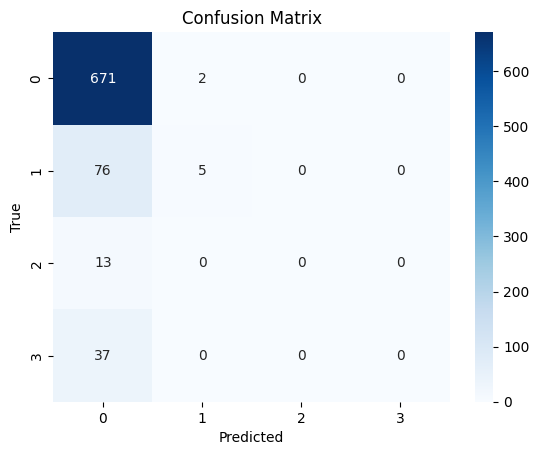

Confusion matrix plotted successfully.


In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix plotted successfully.")
